# Timeseries forecasting using gradient boosting XGBoost

* Introduction
* Import libraries
* Load data and preprocessing
* Set up the hyperparameters
* Feature importance
* Make prediction

## Introduction

This notebook is an example of time series forecasting prediction regarding wave amplitude. For the task, Gradient boosting algorithm (XGBoost) is used. 

## Import libraries

In [13]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import glob

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from itertools import product

from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Load data and preprocessing 

In [16]:
# Preprocessing functions
def wind_uv_to_dir(U,V):
    WDIR= (270-np.rad2deg(np.arctan2(V,U)))%360
    return WDIR

def wind_uv_to_spd(U,V):
    WSPD = np.sqrt(np.square(U)+np.square(V))
    return WSPD

def query_data(PATH):
    df = pd.read_pickle(PATH)
    df['Tp'] = 1/df['fp']
    df['hs'] = df['hs'].astype(float, errors = 'raise')
    df['Tp'] = df['Tp'].astype(float, errors = 'raise')
    df['dp'] = df['dp'].astype(float, errors = 'raise')
    df['uwnd'] = df['uwnd'].astype(float, errors = 'raise')
    df['vwnd'] = df['vwnd'].astype(float, errors = 'raise')
    df['wmag'] = wind_uv_to_spd(df['uwnd'],df['vwnd'])
    df['wdp'] = wind_uv_to_dir(df['uwnd'],df['vwnd'])
    df = df.set_index(df['time']).drop('time',axis=1)
    return df

def create_features(df, label=None,wind=True):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
   
    if wind:
        X = df[['hour','dayofweek','quarter','month','year',
                'dayofyear','dayofmonth','weekofyear','wmag']]
    else:
        X = df[['hour','dayofweek','quarter','month','year',
                'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X


In [30]:
# load the data
PATH = '/mnt/c/PROJETS/ET_WAVE_TOOL/data1994_2019.pkl'
df = query_data(PATH)
df

,hs,fp,dp,uwnd,vwnd,Tp,wmag,wdp
time,,,,,,,,
1994-01-01 00:00:00,2.404706,0.06300000101327896,222.273593,5.600000,-3.700000,15.873016,6.711930,303.453310
1994-01-01 01:00:00,2.478158,0.0650000050663948,224.273593,6.100000,-3.400000,15.384614,6.983552,299.134293
1994-01-01 02:00:00,2.569746,0.06599999964237213,225.273593,6.427359,-2.727359,15.151515,6.982080,292.993255
1994-01-01 03:00:00,2.639611,0.06700000166893005,225.547186,6.700000,-2.427359,14.925373,7.126154,289.915068
1994-01-01 04:00:00,2.659341,0.06700000166893005,226.273593,6.600000,-2.500000,14.925373,7.057620,290.746081
...,...,...,...,...,...,...,...,...
2019-12-01 19:00:00,1.252836,0.09800000488758087,237.341067,0.700000,5.000000,10.204081,5.048762,187.969610
2019-12-01 20:00:00,1.275383,0.09800000488758087,238.273593,1.227359,4.993253,10.204081,5.141885,193.809727
2019-12-01 21:00:00,1.295383,0.09700000286102295,238.273593,1.793253,4.600000,10.309278,4.937181,201.297704


In [46]:
# Resample the data by day using mean
df_resample = pd.DataFrame(df.resample('1D').mean())

# Split the data between train and test sets
train_end = datetime(2013,1,1)
test_end = datetime(2019,12,1)
train_data = pd.DataFrame(df_resample[:train_end])
test_data = pd.DataFrame(df_resample[train_end + relativedelta(day=1):test_end])

Text(0, 0.5, 'Hs [m]')

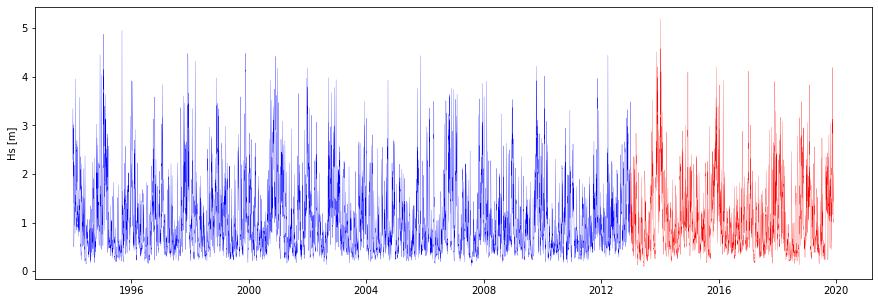

In [48]:
# Plot the dataset
fig=plt.figure(figsize=(15,5))
plt.plot(train_data['hs'],'b',linewidth=0.2)
plt.plot(test_data['hs'],'r',linewidth=0.2)
plt.ylabel('Hs [m]')

In [51]:
# Preprocessing data for the prediction model 
X_train, y_train = create_features(train_data, label='hs',wind=True)
X_test, y_test = create_features(test_data, label='hs',wind=True)

In [105]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,wmag
time,,,,,,,,,
1994-01-01,0,5,1,1,1994,1,1,52,7.814405
1994-01-02,0,6,1,1,1994,2,2,52,8.680659
1994-01-03,0,0,1,1,1994,3,3,1,10.962014
1994-01-04,0,1,1,1,1994,4,4,1,11.515568
1994-01-05,0,2,1,1,1994,5,5,1,11.016122
...,...,...,...,...,...,...,...,...,...
2012-12-28,0,4,4,12,2012,363,28,52,7.646010
2012-12-29,0,5,4,12,2012,364,29,52,8.382402
2012-12-30,0,6,4,12,2012,365,30,52,11.372812


## Set up the hyperparameters

In [52]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:0.72325	validation_1-rmse:0.74823
[1]	validation_0-rmse:0.60116	validation_1-rmse:0.64128
[2]	validation_0-rmse:0.52778	validation_1-rmse:0.58264
[3]	validation_0-rmse:0.48319	validation_1-rmse:0.54296
[4]	validation_0-rmse:0.45694	validation_1-rmse:0.51369
[5]	validation_0-rmse:0.44071	validation_1-rmse:0.49851
[6]	validation_0-rmse:0.42988	validation_1-rmse:0.49055
[7]	validation_0-rmse:0.42232	validation_1-rmse:0.48600
[8]	validation_0-rmse:0.41597	validation_1-rmse:0.48189
[9]	validation_0-rmse:0.41244	validation_1-rmse:0.48015
[10]	validation_0-rmse:0.40930	validation_1-rmse:0.47953
[11]	validation_0-rmse:0.40188	validation_1-rmse:0.47761
[12]	validation_0-rmse:0.39828	validation_1-rmse:0.47772
[13]	validation_0-rmse:0.39190	validation_1-rmse:0.47675
[14]	validation_0-rmse:0.38678	validation_1-rmse:0.47703
[15]	validation_0-rmse:0.38135	validation_1-rmse:0.47849
[16]	validation_0-rmse:0.37750	validation_1-rmse:0.47955
[17]	validation_0-rmse:0.37046	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

##  Feature importance

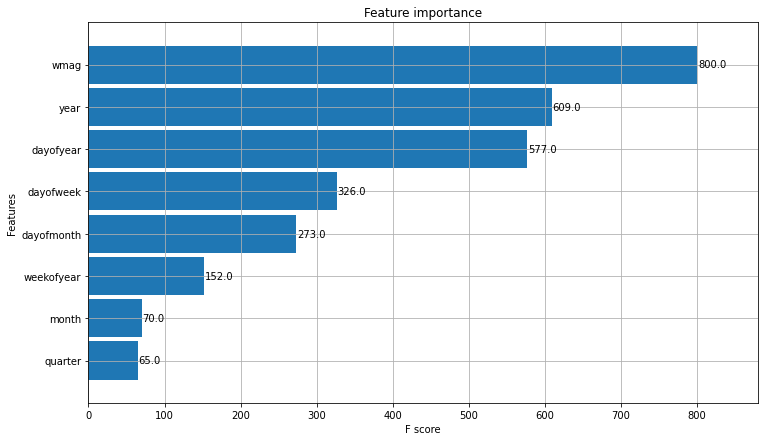

In [53]:
plt.rc("figure", figsize=(12,7))
_ = plot_importance(reg, height=0.9)

## Make prediction

****** RMSE : 0.47675055259893034 ******


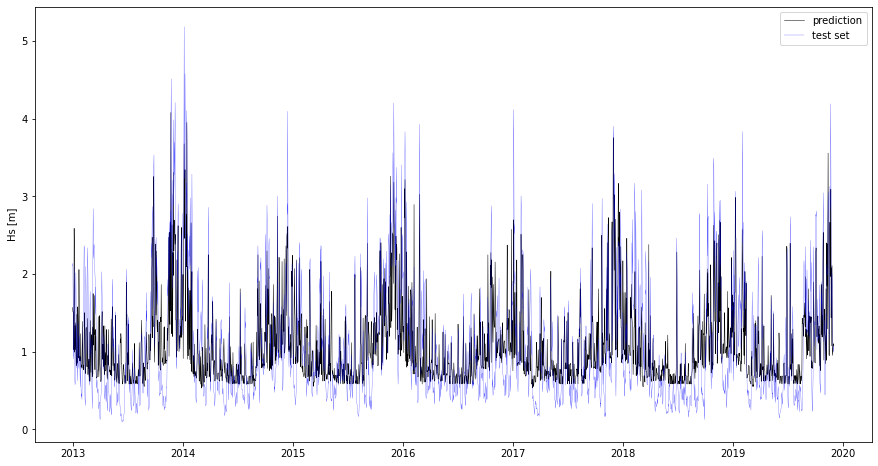

In [100]:
test_data['hs_Prediction'] = reg.predict(X_test)
all_data = pd.concat([test_data, train_data], sort=False)

fig = plt.figure(figsize=(15,8))
plt.plot(test_data['hs_Prediction'],'black',linewidth=0.5,label='prediction')
plt.plot(y_test,'b',linewidth=0.2, label='test set')
plt.ylabel('Hs [m]')
plt.legend()

RMSE = np.sqrt(mean_squared_error(y_test,test_data['hs_Prediction']))
print('****** RMSE : {} ******'.format(RMSE))

Text(0, 0.5, 'Hs [m]')

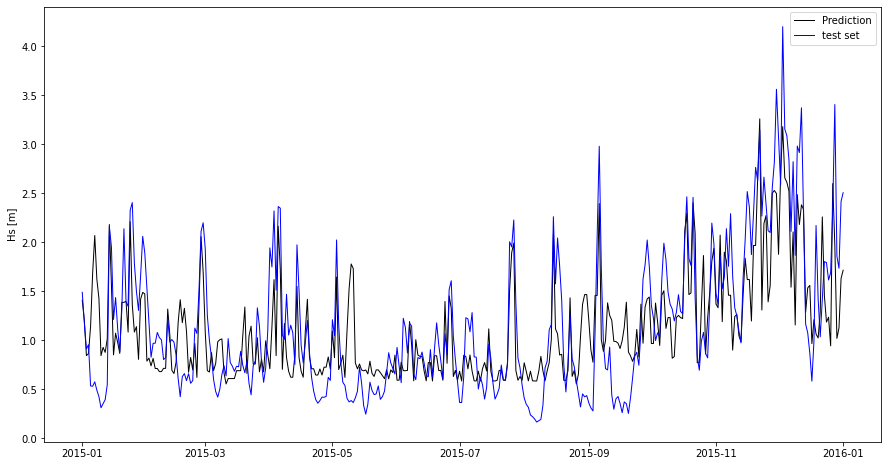

In [103]:
fig = plt.figure(figsize=(15,8))
plt.plot(test_data['hs_Prediction']['2015-01-01':'2016-01-01'],'black',linewidth=1,label='Prediction')
plt.plot(y_test['2015-01-01':'2016-01-01'],'b',linewidth=1,label='test set')
plt.legend()
plt.ylabel('Hs [m]')